In [1]:
%load_ext autoreload
%autoreload 2

# import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
# from tensorflow.keras.datasets import mnist
import sys
from torchvision import datasets, transforms
from tqdm import tqdm
from scipy.spatial.distance import euclidean

sys.path.insert(0, '../..')

from src.covertree import CoverTree 
from src.dyadictree import DyadicTree
# from src.dyadictree import tree_traverse
from src.wavelettree import WaveletTree
# from src.wavelettree import my_fgwt, my_igwt
from src.utils import *

In [2]:
pwd # test present working directory

'/scratch/lmnt/geometric_analysis_hd/experiments/cifar10'

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# Download and load the CIFAR-10 training data
cifar10_train = datasets.CIFAR10(root='../../datasets', train=True, download=True, transform=transform)
X = np.stack([np.array(img[0].numpy()) for img in cifar10_train][:100])  # shape: (1000, 3, 32, 32)

print(X.shape)
# plt.figure()
# plt.imshow(np.transpose(X[0], (1, 2, 0)))
# plt.title('CIFAR-10 Image')

Files already downloaded and verified
(100, 3, 32, 32)


### cifar

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# params
p_n_points = X.shape[0]
print(p_n_points)


100


In [5]:
# compute scale max scale = ceil(log_2(max(||x_i, x_j||_2^2)))
# it is the maximum distance between two points in X
p_covertree_scale = np.ceil(np.log2(np.max([np.linalg.norm(X[i] - X[j]) for i in range(p_n_points) for j in range(i + 1, p_n_points)])))
print(p_covertree_scale)


6.0


In [ ]:
# build the cover tree
import torch # must include before mcas_gmra
from tqdm import tqdm

if type(X) is not torch.Tensor:
    X = torch.from_numpy(X).float()
# make dim 2 if not
if len(X.shape) != 2:
    X = X.reshape(X.shape[0], -1)

In [7]:
X.shape

torch.Size([100, 3072])

In [ ]:
from scipy.spatial.distance import euclidean
python_covertree =  CoverTree(X, euclidean, leafsize=1)
mydiadic_tree    =  DyadicTree(python_covertree)

In [9]:
# tree_traverse(mydiadic_tree.root, level=0)

In [10]:
print(mydiadic_tree.height)

5


In [11]:
mydiadic_tree.root[0]

In [12]:
wavelet_tree = WaveletTree(mydiadic_tree, X, 0, X.shape[-1], inverse=True,
                           thresholds=.5) # inverse means data in (n,d) formatdj

info: computing basis and wavelets for dyadic tree of height 5
info: this may take time..
info: making wavelet tree
info: making wavelets
info: making transforms at level 4
info: making transforms at level 3
info: making transforms at level 2
info: making transforms at level 1
info: making transforms at level 0


In [13]:
mydiadic_tree.root

In [14]:
wavelet_tree.make_wavelets(X)

info: making wavelets
info: making transforms at level 4
info: making transforms at level 3
info: making transforms at level 2
info: making transforms at level 1
info: making transforms at level 0


In [15]:
X = X.numpy()

In [16]:
import copy
#X : (n, d)
def my_fgwt(wavelet_tree, X):
    J = depth(wavelet_tree.root)
    leafs = get_leafs(wavelet_tree.root)

    Qjx = [None] * X.shape[0]
    max_lvl = 0
    for leaf in leafs:
        data_idx  = int(leaf.idxs[0])
        # print(int(data_idx))

        pjx = leaf.basis @ (X[data_idx:data_idx+1,:].T-leaf.center)
        qjx = leaf.wav_basis  @ leaf.basis.T @ pjx
        Qjx[data_idx]=[qjx]

        pJx = pjx
        
        p = path(leaf)

        # pjx = pJx
        # ct = 0
        lvl_counter = len(p)
        # print('lvl_counter', lvl_counter)   
        # print('lvl_counter', lvl_counter)
        for n in reversed(p[1:-1]):
            pjx = n.basis @ leaf.basis.T @ pJx + \
                    n.basis @ ( leaf.center - n.center ) 
            # print(n.wav_basis.shape, n.basis.T.shape, pjx.shape)
            qjx = n.wav_basis @ n.basis.T @ pjx
            Qjx[data_idx].append(qjx)
            # print('a')
            # lvl_counter-=1
            # print('done', lvl_counter)
            # pJx = pJx + p.basis @ (p.center - p.parent.center)
            # print(qjx.shape)
        n = p[0]
        pjx = n.basis @ leaf.basis.T @ pJx + n.basis @ ( leaf.center - n.center ) 
        qjx = pjx
        Qjx[data_idx].append(qjx)
        Qjx[data_idx] = list(reversed(Qjx[data_idx]))
    return Qjx

gmra_q_coeff = my_fgwt(wavelet_tree, X)

In [17]:
gmra_q_coeff[1]

[array([[-1.4974871 ],
        [-0.55183476],
        [ 7.383396  ],
        [ 1.7991464 ],
        [-0.14331853]], dtype=float32),
 array([[6.1588273]], dtype=float32),
 array([], shape=(0, 1), dtype=float64)]

In [18]:
from tqdm import tqdm
def my_igwt(wavelet_tree, gmra_q_coeff):
    J_max = depth(wavelet_tree.root)

    X_recon = np.zeros_like(X)
    # idx_reconstructed  = []
    for leaf in tqdm(get_leafs(wavelet_tree.root)):
        data_idx  = leaf.idxs[0]
        # print('reconstructing', data_idx)
        # idx_reconstructed.append(data_idx)
        # print('data_idx', data_idx)
        chain = path(leaf)
        
        ct=-1

        Qjx = leaf.wav_basis.T @ gmra_q_coeff[data_idx][ct] + leaf.wav_consts

        new_chain = chain[1:-1]
        for jj, n in reversed(list(enumerate(new_chain))):
            # print(len(gmra_q_coeff[data_idx]))
            ct-=1
            Qjx += (n.wav_basis.T @ gmra_q_coeff[data_idx][ct] + n.wav_consts +
                    new_chain[jj-1].basis.T @ new_chain[jj-1].basis @ Qjx)
            # print(ct)
        ct-=1
        Qjx += chain[0].basis.T@ gmra_q_coeff[data_idx][ct] + chain[0].center 
        X_recon[data_idx:data_idx+1,:] = Qjx.T
    return X_recon
        
X_recon  = my_igwt(wavelet_tree, gmra_q_coeff)   
# my_igwt(wavelet_tree, gmra_q_coeff) 

  6%|▌         | 6/100 [00:00<00:03, 24.24it/s]

100%|██████████| 100/100 [00:03<00:00, 29.77it/s]


In [19]:
# now revert back to N C HW
# first convert to N, 32, 32, 3
# X_recon = np.reshape(X_recon, (X_recon.shape[0], 32, 32, 3))
# # then transpose to N, 3, 32, 32
# X_recon = np.transpose(X_recon, (0, 3, 1, 2))  # shape: (1000, 3, 32, 32)

# X_recon.shape

In [20]:
print(X_recon.shape)

(100, 3072)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0069250166..0.8555645].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.045848094..1.1264353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10497964..1.1728466].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0512892..0.94981563].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.048329175..0.94011235].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.016049266..1.0210888].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range 

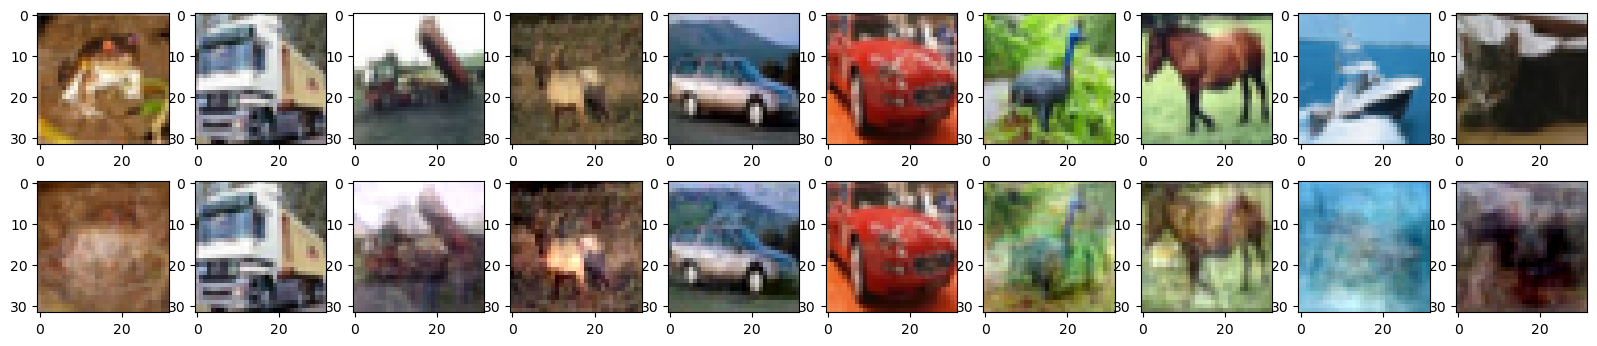

In [21]:
fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    ax[0, i].imshow(np.transpose(X[i].reshape(3, 32, 32), (1, 2, 0)))
    ax[1, i].imshow(np.transpose(X_recon[i].reshape(3, 32, 32), (1, 2, 0)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12175722..0.59538823].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02947265..1.0139277].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17732489..0.88177955].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09127435..1.0686733].


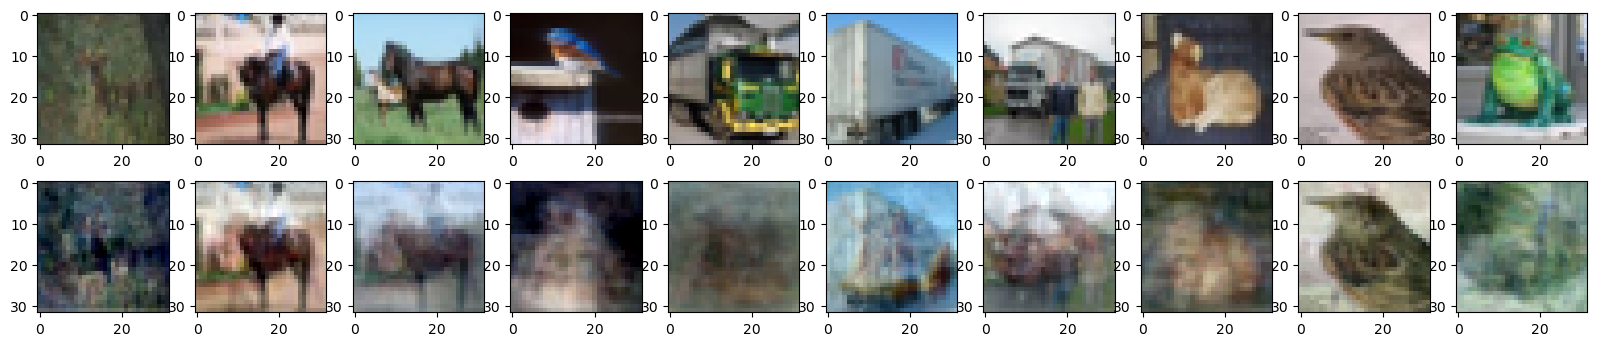

In [22]:
fig, ax = plt.subplots(2, 10, figsize=(20, 4))
ct = 0
for i in range(10,20):
    ax[0, ct].imshow(np.transpose(X[i].reshape(3, 32, 32), (1, 2, 0)))
    ax[1, ct].imshow(np.transpose(X_recon[i].reshape(3, 32, 32), (1, 2, 0)))
    ct+=1